<a href="https://colab.research.google.com/github/SebastianBentert/example_code/blob/main/bing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U matplotlib


# Load Functions

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statistics import mean, stdev
from itertools import combinations
import numpy as np
from scipy.stats import shapiro, mannwhitneyu, ttest_ind
pd.options.mode.chained_assignment = None

In [ ]:
def datenvergleich(x,y):
  """
  First performs a shapiro test, afterwards either a t- or u-test.
  Takes two lists as input
  """
  _, px = shapiro(x)
  _, py = shapiro(y)
  print(px,py)
  if px <= 0.05 and py <= 0.05:
    _, p2 = mannwhitneyu(x, y)
    if p2 <= 0.05:
      print(f'keine Normalverteilung\nDaten sind unterschiedlich\nU-Test P-wert = {round(p2,3)}')
    else:
      print(f'keine Normalverteilung\nDaten sind nicht unterschiedlich\nU-Test P-wert = {round(p2,3)}')
  else:
    _, p2 = ttest_ind(x, y)
    if p2 <= 0.05:
      print(f'Normalverteilung\nDaten sind unterschiedlich\nT-Test P-wert = {round(p2,3)}')
    else:
      print(f'Normalverteilung\nDaten sind nicht unterschiedlich\nT-Test P-wert = {round(p2,3)}')
    

In [ ]:
def shapirotests(daten,names):
  for x,y in combinations(range(len(daten)),2):
    print(f'\nVergleich von {names[x]} und {names[y]}:')
    datenvergleich(daten[x],daten[y])

In [ ]:
def proteinvoll(unb,u,ue,e,unb2,u2,ue2,e2,c,vf):
  '''
  Alle 4 tests (unbehandelt, U, UE, E)
  '''
  df = pd.DataFrame(data=[[unb,unb2,mean(unb),stdev(unb),mean(unb2),stdev(unb2)],[u,u2,mean(u),stdev(u),mean(u2),stdev(u2)],[ue,ue2,mean(ue),stdev(ue),mean(ue2),stdev(ue2)],[e,e2,mean(e),stdev(e),mean(e2),stdev(e2)]],
                    index=['unb','U','UE','E'],
                    columns=['Messungen Blindwert','Messungen LPl','BW mean','BW std','LPl mean','LPl std'])
  df['bw']=df['LPl mean']-df['BW mean']
  df['VF']=vf
  df['absorb']=df['bw']*df['VF']
  df['protein g/L'] = (df['bw']-0.0068)/0.054
  df['Protein mit VF g/L'] = df['protein g/L']*df['VF']
  df['Protein %'] = df['Protein mit VF g/L']/10
  fig = plt.figure(figsize=(10,7))
  ax = df['Protein %'].plot(kind='bar',yerr=df['LPl std']/df['LPl mean']*df['Protein %'])
  plt.title('Proteingehalt %')
  for p in ax.patches:
    ax.annotate('{:.2f}'.format(round(p.get_height(),2))+'%', (p.get_x()+0.13, p.get_height() +0.2))
  # shapiro tests
  unbshapiro = [(((np.array(df['Messungen LPl']['unb'])-np.array(df['Messungen Blindwert']['unb']))-0.0068)/0.054)*df['VF']['unb'],'unbehandelt']
  Ushapiro = [(((np.array(df['Messungen LPl']['U'])-np.array(df['Messungen Blindwert']['U']))-0.0068)/0.054)*df['VF']['U'],'U']
  UEshapiro = [(((np.array(df['Messungen LPl']['UE'])-np.array(df['Messungen Blindwert']['UE']))-0.0068)/0.054)*df['VF']['UE'],'UE']
  Eshapiro = [(((np.array(df['Messungen LPl']['E'])-np.array(df['Messungen Blindwert']['E']))-0.0068)/0.054)*df['VF']['E'],'E']
  for x,y in combinations([unbshapiro,Ushapiro,UEshapiro,Eshapiro],2):
    print(f'\nVergleich von {x[1]} und {y[1]}:')
    datenvergleich(x[0],y[0])
  for col in ['Messungen Blindwert','Messungen LPl']:
    for index, row in df.iterrows():
      df[col][index] = '  '.join([str(n) for n in df[col][index]]).replace('.',',')
  df.index = df.index+' '+str(c) 
  df.to_excel('Proteinanalyse.xlsx')
  fig.savefig('Proteinplot')

In [ ]:
def protein(LPl,BW,names,vf,c):
  df = pd.DataFrame(columns=['Messungen Blindwert','Messungen LPl','BW mean','BW std','LPl mean','LPl std'])
  for i in range(len(LPl)):
    df.loc[names[i]] = [BW[i],LPl[i],mean(BW[i]),stdev(BW[i]),mean(LPl[i]),stdev(LPl[i])]
  df['Probe-Blindwert']=df['Messungen LPl']
  for index, row in df.iterrows():
    df['Probe-Blindwert'][index] = [x-df['BW mean'][index] for x in df['Messungen LPl'][index]]
  df['VF']=vf
  df['protein g/L2'] = df['Messungen LPl']
  df['protein g/L'] = 0.
  df['Protein %2'] = df['Messungen LPl']
  df['Protein %'] = 0.
  df['Protein stdev'] = np.nan
  for index, row in df.iterrows():
    df['protein g/L2'][index] = [(x-0.0068)/0.054 for x in df['Probe-Blindwert'][index]]
    df['Protein %2'][index] = [x*df['VF'][index]/10 for x in df['protein g/L2'][index]]
    df['protein g/L'][index] = mean(df['protein g/L2'][index])
    df['Protein %'][index] = mean(df['Protein %2'][index])
    df['Protein stdev'][index] = stdev(df['Protein %2'][index])
  
  d = {}
  for index, row in df.iterrows():
    d[index] = list((((np.array(df['Messungen LPl'][index])-np.array(df['Messungen Blindwert'][index]))-0.0068)/0.054)*df['VF'][index])
  
  for x,y in combinations([key for key in d],2):
    print(f'\nVergleich von {x} und {y}:')
    datenvergleich(d[x],d[y])
  df.index = df.index+' '+str(c)
  df[['Protein %','Protein stdev','protein g/L','LPl mean','BW mean']] = df[['Protein %','Protein stdev','protein g/L','LPl mean','BW mean']].round(2)
  df['Protein stdev'] = df['Protein stdev'].round(2)
  for index, row in df.iterrows():
    df['Protein %2'][index] = [round(x,2) for x in df['Protein %2'][index]]
    df['protein g/L2'][index] = [round(x,2) for x in df['protein g/L2'][index]]
  for col in ['Messungen Blindwert','Messungen LPl','Probe-Blindwert','Protein %2','protein g/L2']:
    for index, row in df.iterrows():
      df[col][index] = '  '.join([str(n) for n in df[col][index]]).replace('.',',')
  df['Protein in %']=""
  df['Proteingehalt']=""
  for index, row in df.iterrows():
    df['Protein in %'][index]=str(df['Protein %'][index])+' ('+df['Protein %2'][index]+')'
    df['Proteingehalt'][index]=str(df['protein g/L'][index])+' ('+df['protein g/L2'][index]+')'
  fig = plt.figure(figsize=(10,7))
  bar = plt.bar(x=names,height=df['Protein %'],yerr=[df['Protein stdev']])
  plt.title('Proteingehalt in %')
  plt.bar_label(bar)
  df = df[['Messungen Blindwert','BW mean','Messungen LPl','LPl mean','Probe-Blindwert','VF','Proteingehalt','Protein in %','Protein stdev']]
  df.to_excel('Proteinanalyse.xlsx')
  fig.savefig('Proteinplot')

In [ ]:
def Trübungvoll(unb,u,ue,e,unb2,u2,ue2,e2,vf):
  unb,u,ue,e,unb2,u2,ue2,e2 = np.array(unb),np.array(u),np.array(ue),np.array(e),np.array(unb2),np.array(u2),np.array(ue2),np.array(e2)
  df = pd.DataFrame(data=[[unb,unb2,mean(unb),stdev(unb),mean(unb2),stdev(unb2)],[u,u2,mean(u),stdev(u),mean(u2),stdev(u2)],[ue,ue2,mean(ue),stdev(ue),mean(ue2),stdev(ue2)],[e,e2,mean(e),stdev(e),mean(e2),stdev(e2)]],
                    index=['unb','U','UE','E'],
                    columns=['Absorbtion Blindwert','Absorbtion LPl','BW mean','BW std','LPl mean','LPl std'])
  df['Transmission% LPl'] = (10**-df['Absorbtion LPl'])*100
  df['Transmission% LPl mean'] = (10**-df['LPl mean'])*100
  df['Transmission% BW'] = (10**-df['Absorbtion Blindwert'])*100
  df['Transmission% BW mean'] = (10**-df['BW mean'])*100
  df['Transmission Effektiv%'] = (df['Transmission% LPl']/df['Transmission% BW'])*100
  df['Transmission Effektiv% mean'] = (df['Transmission% LPl mean']/df['Transmission% BW mean'])*100
  df['Trübung%'] = 100 - df['Transmission Effektiv% mean']

  for x,y in combinations([(df['Transmission Effektiv%']['unb'],'unb'),(df['Transmission Effektiv%']['U'],'U'),(df['Transmission Effektiv%']['UE'],'UE'),(df['Transmission Effektiv%']['E'],'E')],2):
    print(f'\nVergleich von {x[1]} und {y[1]}:')
    datenvergleich(x[0],y[0])
  fig = plt.figure(figsize=(10,7))
  ax = df['Trübung%'].plot(kind='bar')
  plt.title('Trübung%')
  for p in ax.patches:
    ax.annotate('{:.2f}'.format(round(p.get_height(),2))+'%', (p.get_x()+0.13, p.get_height() +0.2))
  for col in ['Absorbtion Blindwert','Absorbtion LPl','Transmission% BW','Transmission% LPl','Transmission Effektiv%']:
    for index, row in df.iterrows():
      df[col][index] = '  '.join([str(n) for n in df[col][index]]).replace('.',',')
  df.to_excel('Trübung.xlsx')
  fig.savefig('Trübungsplot')

In [ ]:
def Trübung(LPl,BW,names,vf):
  df = pd.DataFrame(columns=['Absorbtion Blindwert','Absorbtion LPl','BW mean','BW std','LPl mean','LPl std'])
  for i in range(len(LPl)):
    df.loc[names[i]] = [np.array(BW[i]),np.array(LPl[i]),mean(BW[i]),stdev(BW[i]),mean(LPl[i]),stdev(LPl[i])]
  df['Transmission% LPl'] = (10**-df['Absorbtion LPl'])*100
  df['Transmission% LPl mean'] = (10**-df['LPl mean'])*100
  df['Transmission% BW'] = (10**-df['Absorbtion Blindwert'])*100
  df['Transmission% BW mean'] = (10**-df['BW mean'])*100
  df['Transmission Effektiv%'] = (df['Transmission% LPl']/df['Transmission% BW'])*100
  df['Transmission Effektiv% mean'] = (df['Transmission% LPl mean']/df['Transmission% BW mean'])*100
  df['Trübung%'] = 100 - df['Transmission Effektiv% mean']
  fig = plt.figure(figsize=(10,7))
  ax = df['Trübung%'].plot(kind='bar')
  plt.title('Trübung%')
  for p in ax.patches:
    ax.annotate('{:.2f}'.format(round(p.get_height(),2))+'%', (p.get_x()+0.13, p.get_height() +0.2))
  records = df[['Transmission Effektiv%']].to_records(index=True)
  print(records)
  for x,y in combinations(records,2):
    print(f'\nVergleich von {x[0]} und {y[0]}:')
    datenvergleich(x[1],y[1])
  for col in ['Absorbtion Blindwert','Absorbtion LPl','Transmission% BW','Transmission% LPl','Transmission Effektiv%']:
    for index, row in df.iterrows():
      df[col][index] = '  '.join([str(n) for n in df[col][index]]).replace('.',',')
  df.to_excel('Trübungcustom.xlsx')
  fig.savefig('Trübungcustomplot')

In [ ]:
def dataframer(Daten,names,title=None,saveplot=False,savexlsx=False):
  df = pd.DataFrame(columns=['Messungen','mean','std'])
  for i in range(len(Daten)):
    df.loc[names[i]] = [Daten[i],mean(Daten[i]),stdev(Daten[i])]
  fig = plt.figure(figsize=(10,7))
  ax = df['mean'].plot(kind='bar',yerr=df['std'])
  if title:
    plt.title(title)
  for p in ax.patches:
    ax.annotate('{:.2f}'.format(round(p.get_height(),2)), (p.get_x()+0.13, p.get_height()*1.005))
  print(df.T)
  d = {}
  for index, row in df.iterrows():
    d[index] = df['Messungen'][index]
  for x,y in combinations([key for key in d],2):
    print(f'\nVergleich von {x} und {y}:')
    datenvergleich(d[x],d[y])
  for index, row in df.iterrows():
    df['Messungen'][index] = '  '.join([str(n) for n in df['Messungen'][index]]).replace('.',',')
  if savexlsx:
    df.to_excel(f'{savexlsx}.xlsx')
  if saveplot:
    fig.savefig(f'{saveplot}')

def Partikelgröße(Daten,names):
  dataframer(Daten,names,title='Partikelgröße in μm',saveplot='Partikelgrößeplot',savexlsx='Partikelgröße')

def Zeta(Daten,names):
  dataframer(Daten,names,title='Zetapotential',saveplot='Zetapotentialplot',savexlsx='Zetapotential')

# Use functions

## Shapiro, U/T-Test

In [ ]:
# Zu vergleichende Daten
x = [0.148,0.146,0.146]
y = [0.15,0.15,0.15]
datenvergleich(x = x,
               y = y)

Normalverteilung
Daten sind unterschiedlich
T-Test P-wert = 0.007


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1673: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


## Shapiro mit mehr als 2 Datensätzen

In [ ]:
q = [1,1,1]
w = [2,2,2]
e = [3,4,5]
daten = [q,w,e]
datennamen = ['q','w','e']

shapirotests(daten,datennamen)


Vergleich von q und w:
1.0 1.0
Normalverteilung
Daten sind unterschiedlich
T-Test P-wert = 0.0

Vergleich von q und e:
1.0 0.999998927116394
Normalverteilung
Daten sind unterschiedlich
T-Test P-wert = 0.007

Vergleich von w und e:
1.0 0.999998927116394
Normalverteilung
Daten sind unterschiedlich
T-Test P-wert = 0.026


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1673: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


## Proteinanalyse mit 4 Behandlungsmethoden


Vergleich von unbehandelt und U:
0.46326205134391785 0.6368904113769531
Normalverteilung
Daten sind unterschiedlich
T-Test P-wert = 0.0

Vergleich von unbehandelt und UE:
0.46326205134391785 0.6368833780288696
Normalverteilung
Daten sind unterschiedlich
T-Test P-wert = 0.0

Vergleich von unbehandelt und E:
0.46326205134391785 -9.106917104872991e-07
Normalverteilung
Daten sind unterschiedlich
T-Test P-wert = 0.0

Vergleich von U und UE:
0.6368904113769531 0.6368833780288696
Normalverteilung
Daten sind unterschiedlich
T-Test P-wert = 0.0

Vergleich von U und E:
0.6368904113769531 -9.106917104872991e-07
Normalverteilung
Daten sind unterschiedlich
T-Test P-wert = 0.0

Vergleich von UE und E:
0.6368833780288696 -9.106917104872991e-07
Normalverteilung
Daten sind unterschiedlich
T-Test P-wert = 0.001


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


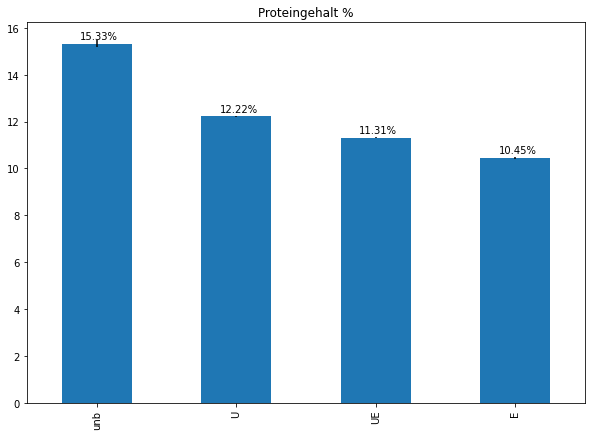

In [ ]:
#Nicht aktulaisiert, benutze nächste Funktion
"""
# Blindwerte (unb = unbehandelt, U = Ultraschall, UE = Ultraschall+erhitzt, E = erhitzt)
BWunb = [0.128,0.127,0.129]
BWU = [0.128,0.127,0.129]
BWUE=[0.128,0.127,0.129]
BWE=[0.15,0.15,0.15]

# Lupinlösungswerte
LPunb=[0.370,0.375,0.369]
LPU=[0.323,0.324,0.323]
LPUE=[0.309,0.310,0.309]
LPE=[0.319,0.319,0.316]

# Konzentration
C = 17.5

# Verdünnungsfaktor
VF = C/0.5
proteinvoll(unb = BWunb,
      u = BWU,
      ue = BWUE,
      e = BWE,
      unb2 = LPunb,
      u2 = LPU,
      ue2 = LPUE,
      e2 = LPE,
      c = C,
      vf = VF)
"""

## Proteinanalye mit mehr oder weniger Behandlungen als 4


Vergleich von US2.5. und US7.5:
0.46326613426208496 0.6368833780288696
Normalverteilung
Daten sind unterschiedlich
T-Test P-wert = 0.0

Vergleich von US2.5. und US15:
0.46326613426208496 0.6368904113769531
Normalverteilung
Daten sind unterschiedlich
T-Test P-wert = 0.0

Vergleich von US7.5 und US15:
0.6368833780288696 0.6368904113769531
Normalverteilung
Daten sind unterschiedlich
T-Test P-wert = 0.0


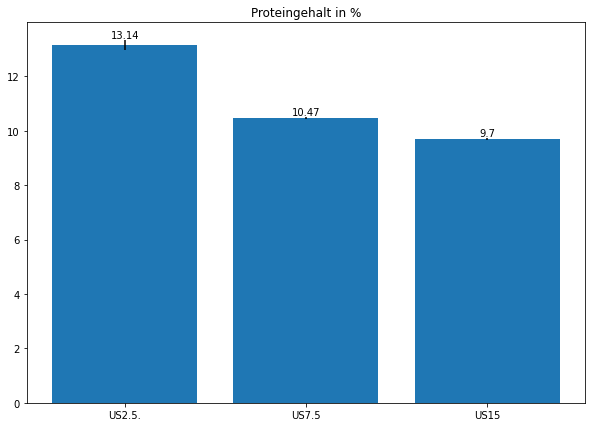

In [ ]:
US2_5BW = [0.128,0.127,0.129]
US2_5SP = [0.370,0.375,0.369]
US7_5BW = [0.128,0.127,0.129]
US7_5SP = [0.323,0.324,0.323]
US15BW = [0.128,0.127,0.129]
US15SP = [0.309,0.310,0.309]
datenLPl=[US2_5SP,US7_5SP,US15SP]
datenBW=[US2_5BW,US7_5BW,US15BW]
datennamen = ['US2.5.','US7.5','US15']
C = 15
VF = C/0.5
protein(LPl = datenLPl,
      BW = datenBW,
      names = datennamen,
      vf = VF,
      c = C)

## Trübung mit 4 Behandlungsmethoden


Vergleich von unb und U:
-9.106917104872991e-07 -9.106917104872991e-07
keine Normalverteilung
Daten sind unterschiedlich
U-Test P-wert = 0.036

Vergleich von unb und UE:
-9.106917104872991e-07 -9.106917104872991e-07
keine Normalverteilung
Daten sind unterschiedlich
U-Test P-wert = 0.036

Vergleich von unb und E:
-9.106917104872991e-07 0.017730483785271645
keine Normalverteilung
Daten sind nicht unterschiedlich
U-Test P-wert = 0.329

Vergleich von U und UE:
-9.106917104872991e-07 -9.106917104872991e-07
keine Normalverteilung
Daten sind unterschiedlich
U-Test P-wert = 0.036

Vergleich von U und E:
-9.106917104872991e-07 0.017730483785271645
keine Normalverteilung
Daten sind nicht unterschiedlich
U-Test P-wert = 0.329

Vergleich von UE und E:
-9.106917104872991e-07 0.017730483785271645
keine Normalverteilung
Daten sind nicht unterschiedlich
U-Test P-wert = 0.329


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


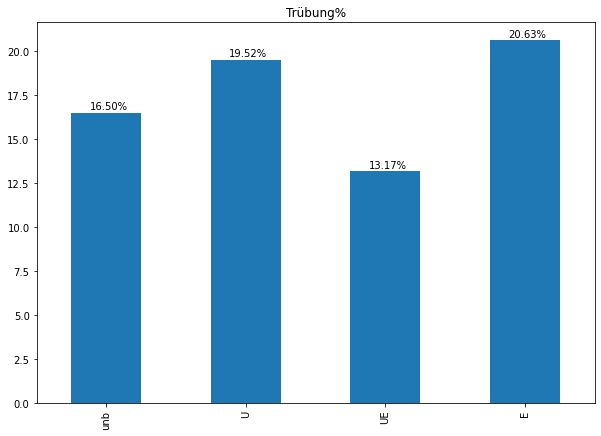

In [ ]:
BWUNB=[0.055,0.054,0.055]
BWU=[0.055,0.054,0.055]
BWUE=BWUNB
BWE=BWU
LPUNB=[0.133,0.133,0.133]
LPU=[0.149,0.149,0.149]
LPUE=[0.116,0.116,0.116]
LPE=[0.099,0.183,0.183]
VF = 15
Trübungvoll(unb=BWUNB,
        u=BWU,
        ue=BWUE,
        e=BWE,
        unb2=LPUNB,
        u2=LPU,
        ue2=LPUE,
        e2=LPE,
        vf=VF)

## Trübung mit mehr oder weniger Behandlungen als 4

[('2,5min US', array([66.98846094, 66.98846094, 66.98846094]))
 ('7,5min US', array([70.30723199, 70.30723199, 70.30723199]))]

Vergleich von 2,5min US und 7,5min US:
Normalverteilung
Daten sind unterschiedlich
shapiro P-Wert = 1.0, T-Test P-wert = 0.0


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1673: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


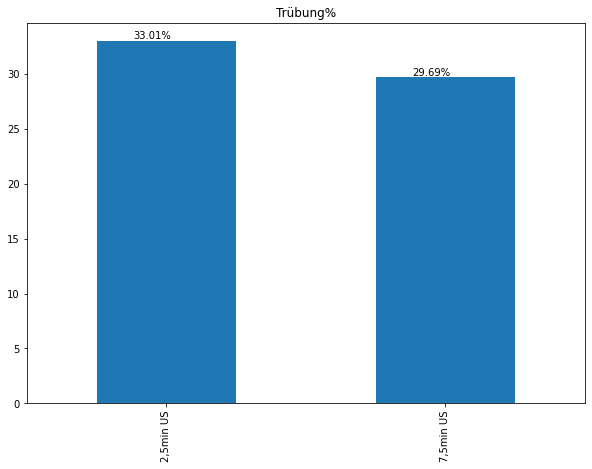

In [ ]:
UE1410BW = [0.055,0.055,0.055]
UE1410LP = [0.230,0.230,0.230]
UE0710BW = [0.056,0.056,0.056]
UE0710LP = [0.209,0.209,0.209]
datenLPl=[UE1410LP,UE0710LP]
datenBW=[UE1410BW,UE0710BW]
datennamen = ['2,5min US','7,5min US']
VF = 15
Trübung(LPl = datenLPl,
      BW = datenBW,
      names = datennamen,
      vf = VF)

## Partikelgröße

                                     1  ...                            3
Messungen  [1.16985, 1.12375, 1.14101]  ...  [1.15712, 1.06803, 1.02941]
mean                           1.14487  ...                     1.084853
std                           0.023291  ...                     0.065496

[3 rows x 3 columns]

Vergleich von  1 und 2:
0.7249401807785034 0.9724370837211609
Normalverteilung
Daten sind unterschiedlich
T-Test P-wert = 0.006

Vergleich von  1 und 3:
0.7249401807785034 0.5715701580047607
Normalverteilung
Daten sind nicht unterschiedlich
T-Test P-wert = 0.209

Vergleich von 2 und 3:
0.9724370837211609 0.5715701580047607
Normalverteilung
Daten sind unterschiedlich
T-Test P-wert = 0.041


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


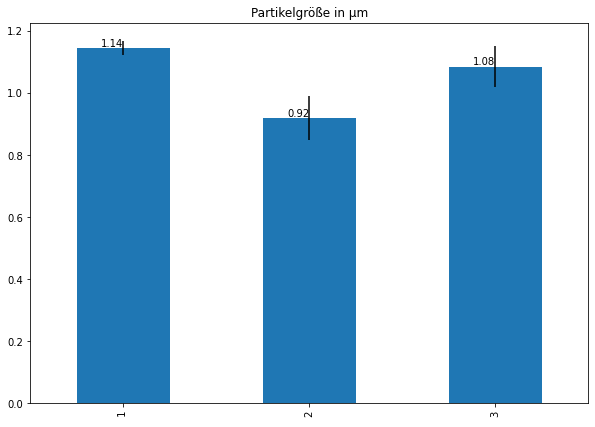

In [ ]:
U = [1.16985,1.12375,1.14101]
UE = [0.84714,0.98997,0.92034]
E = [1.15712,1.06803,1.02941]

daten = [U,UE,E]
datennamen = [" 1","2","3"]
Partikelgröße(Daten=daten,
              names = datennamen)

## Zetapotential

                                             1  ...                                    3
Messungen  [-22.1, -21.6, -21.2, -22.6, -22.9]  ...  [-25.6, -22.4, -24.8, -22.9, -24.9]
mean                                    -22.08  ...                               -24.12
std                                   0.697854  ...                             1.388164

[3 rows x 3 columns]

Vergleich von 1 und 2:
0.8440166711807251 0.18959403038024902
Normalverteilung
Daten sind unterschiedlich
T-Test P-wert = 0.0

Vergleich von 1 und 3:
0.8440166711807251 0.3253594636917114
Normalverteilung
Daten sind unterschiedlich
T-Test P-wert = 0.019

Vergleich von 2 und 3:
0.18959403038024902 0.3253594636917114
Normalverteilung
Daten sind nicht unterschiedlich
T-Test P-wert = 0.2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


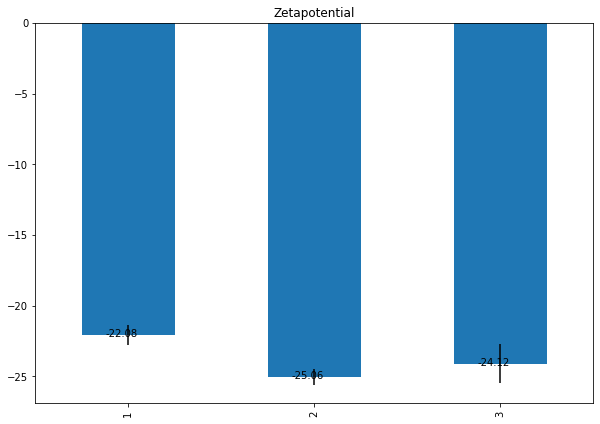

In [ ]:
US25 = [-22.1,-21.6,-21.2,-22.6,-22.9]
US75 = [-24.5,-24.5,-25.0,-25.7,-25.6]
U = [-25.6,-22.4,-24.8,-22.9,-24.9]

daten = [US25,US75,U]
datennamen = ['1',"2","3"]
Zeta(Daten=daten,
     names = datennamen)